# 01: CMB Data Exploration and Preprocessing

### Introduction

This notebook is the first step in the `CosmicLegacy` research project. Its primary goal is to perform all the necessary data sourcing and preparation tasks to create a clean, analysis-ready dataset for our deep learning models.

Our workflow will be as follows:
1.  Set up the required software environment.
2.  Download the official Cosmic Microwave Background (CMB) data from the Planck 2018 mission, along with the corresponding confidence mask.
3.  Load, process, and visualize the data to understand its structure and confirm its integrity.
4.  Convert the full-sky spherical map into a dataset of small, 2D "patches", which is the format required by standard neural networks.
5.  Save the final dataset to our persistent Google Drive storage for use in the next stage of the project.

### Step 1: Environment Setup

Every data science project begins with setting up the proper environment. Here, we perform two critical initial actions:
1.  **Mount Google Drive:** This connects our temporary Colab session to our permanent cloud storage, ensuring that any data we download or create will not be lost.
2.  **Install `healpy`:** We install this specialized library, which is the industry standard for working with data structured in the HEALPix (Hierarchical Equal Area isoLatitude Pixelization) format used by the Planck mission.

In [1]:
# --- Mount Google Drive ---
# This command connects the Colab virtual machine to your personal Google Drive.
# It's essential for saving data, models, and notebooks, ensuring our work
# persists between sessions. You will be prompted for authorization.
from google.colab import drive
drive.mount('/content/drive')

# --- Install HEALPy ---
# The 'healpy' library is a powerful tool specifically designed for working with
# data on a sphere. We will use it to read, visualize, and manipulate the CMB sky map.
!pip install healpy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 51.2 MB/s eta 0:00:00


### Step 2: Imports and Path Definitions

In this cell, we import all the necessary Python libraries for this notebook. We also define the file paths we'll use, centralizing them in one place to make the code cleaner and easier to manage.

-   **`os`**: For interacting with the file system (e.g., creating directories).
-   **`requests`**: A robust library for making HTTP requests to download our data.
-   **`tqdm`**: A utility for creating smart, informative progress bars.
-   **`numpy`**: The fundamental library for numerical operations in Python.
-   **`healpy`**: The core library for processing HEALPix data.
-   **`matplotlib.pyplot`**: The primary library for creating plots and visualizations.

In [2]:
# --- Standard Library Imports ---
import os
import requests
from tqdm.auto import tqdm

# --- Scientific Computing Imports ---
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# --- Path Definitions ---
# Define the absolute path to our project folder on Google Drive.
project_path = '/content/drive/My Drive/CosmicLegacy'
# Define a dedicated sub-folder for storing raw and processed data.
data_path = os.path.join(project_path, 'data')
# Create the data directory if it doesn't already exist.
os.makedirs(data_path, exist_ok=True)

print(f"Project path is set to: {project_path}")
print(f"Data will be stored in: {data_path}")

Project path is set to: /content/drive/My Drive/CosmicLegacy
Data will be stored in: /content/drive/My Drive/CosmicLegacy/data


### Step 3: Data Acquisition

Now we download our two essential data files. We will download them only if they don't already exist in our Google Drive folder.

1.  **CMB Map (`planck_cmb_map.fits`):** This is the component-separated SMICA map from the Planck 2018 data release. It represents the "cleaned" full-sky view of the CMB temperature and polarization, where foreground signals from our own galaxy have been mathematically subtracted.
2.  **Confidence Mask (`COM_Mask_...`):** This is the official mask for the data release. It's a binary map that tells us which pixels on the sky are considered "clean" enough for high-precision cosmological analysis, effectively blocking out the brightest parts of the Milky Way.

In [3]:
# --- Conditional Download for Main CMB Map ---
map_url = "https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-smica_2048_R3.00_full.fits"
map_filename = "planck_cmb_map.fits"
map_filepath = os.path.join(data_path, map_filename)

if not os.path.exists(map_filepath):
    print(f"Main CMB map not found. Starting download...")
    try:
        response = requests.get(map_url, stream=True, timeout=30)
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=map_filename)
        with open(map_filepath, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
        print(f"Download complete! File saved to {map_filepath}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
else:
    print(f"Main CMB map already exists: {map_filepath}")

Main CMB map already exists: /content/drive/My Drive/CosmicLegacy/data/planck_cmb_map.fits


In [4]:
# --- Conditional Download for Mask File ---
mask_url = "https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/masks/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits"
mask_filename = "COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits"
mask_filepath = os.path.join(data_path, mask_filename)

if not os.path.exists(mask_filepath):
    print(f"Official R3 mask not found. Starting download...")
    try:
        response = requests.get(mask_url, stream=True, timeout=30)
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=mask_filename)
        with open(mask_filepath, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
        print(f"Download complete! File saved to {mask_filepath}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
else:
    print(f"Official R3 mask already exists: {mask_filepath}")

Official R3 mask already exists: /content/drive/My Drive/CosmicLegacy/data/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits


### Step 4: Data Loading and Verification

This step loads our two essential files from disk: the original CMB temperature map (`cmb_map_I`) and the binary galactic mask (`galactic_mask`). We visualize them side-by-side to confirm both are correct before proceeding.


Loading all necessary maps from disk...
All files loaded successfully.
Visualizing the source map and the mask...


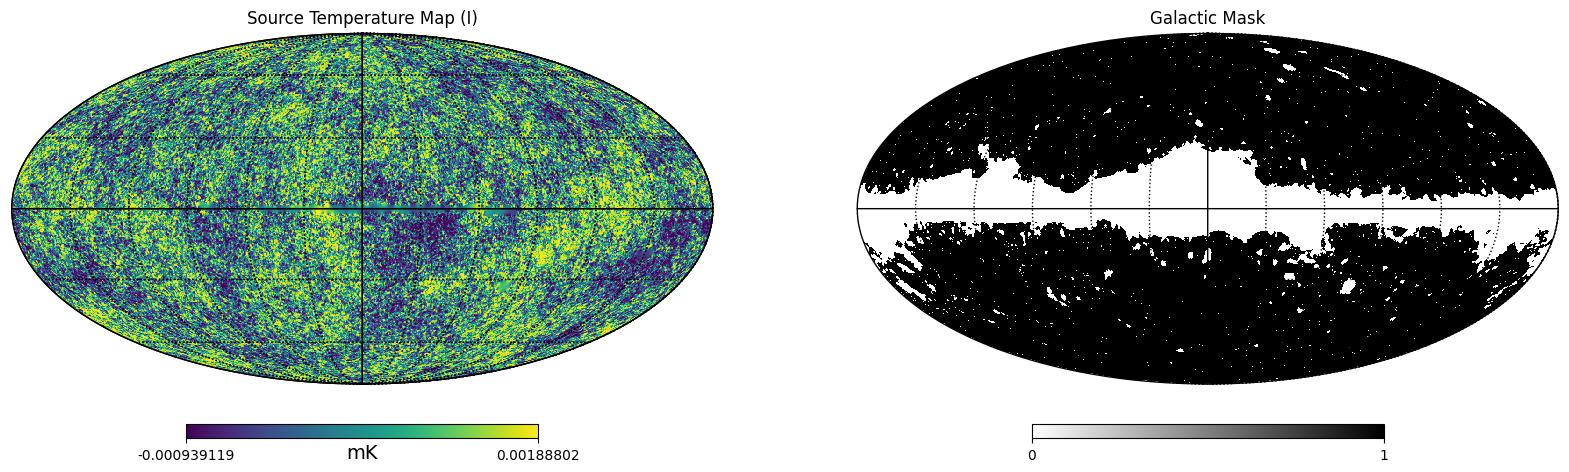

In [5]:
# --- Load Maps and Mask from Disk ---
print("\nLoading all necessary maps from disk...")
# Load the main temperature map.
map_filepath = os.path.join(data_path, "planck_cmb_map.fits")
cmb_map_I = hp.read_map(map_filepath, field=0)

# Load the mask file. We no longer need to convert its data type.
mask_filepath = os.path.join(data_path, "COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits")
galactic_mask = hp.read_map(mask_filepath)
print("All files loaded successfully.")

# --- Visualize for Verification ---
print("Visualizing the source map and the mask...")
plt.figure(figsize=(20, 10))

# Plot the Original CMB Map
plt.subplot(1, 2, 1)
hp.mollview(cmb_map_I, title="Source Temperature Map (I)", unit="mK", norm='hist', cmap='viridis', hold=True)
hp.graticule()

# Plot the Galactic Mask
plt.subplot(1, 2, 2)
hp.mollview(galactic_mask, title="Galactic Mask", cmap='gray_r', hold=True)
hp.graticule()

plt.show()

### Step 5: Patch Generation (Final Version)

This is the final, robust version of our patch generation code. It uses the "project-then-check" method and a relaxed validation condition (`> 0.99`) to account for numerical interpolation effects, ensuring we generate a clean and valid dataset.

Finding valid (unmasked) pixel indices for sampling...
Found 39229084 valid pixels to sample from.

Starting FINAL patch generation with size 32x32...


Searching for Patches:   0%|          | 0/20000 [00:00<?, ?attempts/s]


Finished generation. Successfully generated 1000 patches.
Final dataset shape: (1000, 32, 32)
Displaying a few example patches...


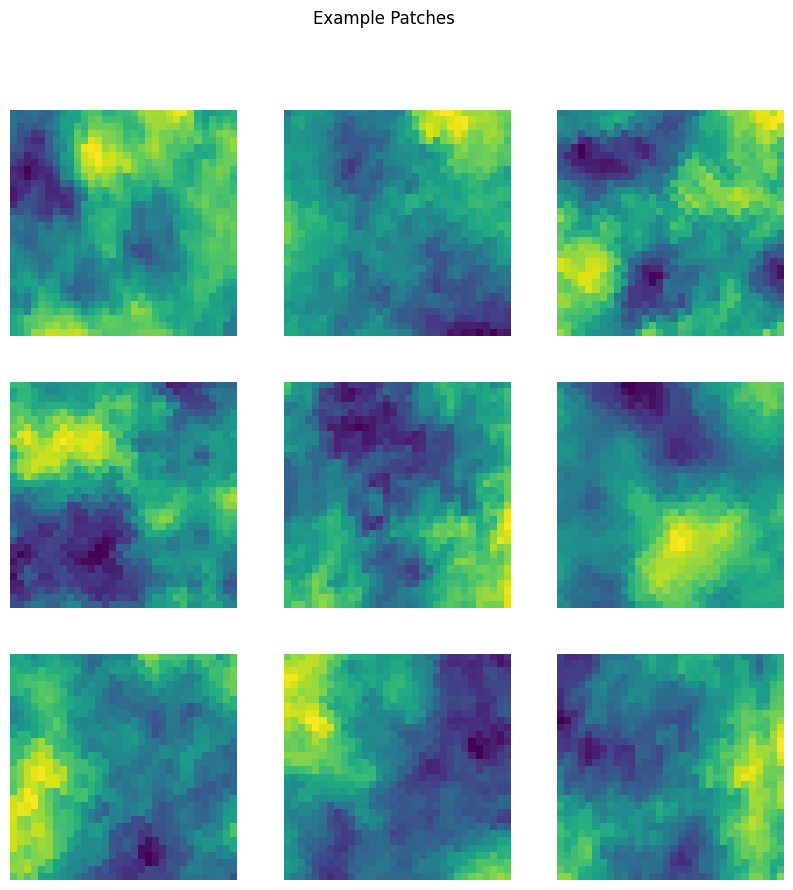

In [8]:
# --- Patch Generation Parameters ---
patch_resolution_pixels = 32
num_patches_to_generate = 1000
patch_dataset = []
# CORRECTED the function name from get_side to get_nside
nside = hp.get_nside(cmb_map_I)

print("Finding valid (unmasked) pixel indices for sampling...")
good_indices = np.where(galactic_mask == 1.0)[0]
print(f"Found {len(good_indices)} valid pixels to sample from.")


print(f"\nStarting FINAL patch generation with size {patch_resolution_pixels}x{patch_resolution_pixels}...")
max_attempts = num_patches_to_generate * 20
progress_bar = tqdm(range(max_attempts), desc="Searching for Patches", unit="attempts")

for _ in progress_bar:
    if len(patch_dataset) >= num_patches_to_generate:
        progress_bar.n = max_attempts
        break

    random_pixel_index = np.random.choice(good_indices)

    # --- CORRECT COORDINATE TRANSFORMATION ---
    theta, phi = hp.pix2ang(nside, random_pixel_index)
    lon_deg = np.rad2deg(phi)
    lat_deg = 90.0 - np.rad2deg(theta)
    rot_params = (lon_deg, lat_deg)

    # --- Project-then-check method ---
    mask_patch = hp.gnomview(
        galactic_mask,
        rot=rot_params,
        xsize=patch_resolution_pixels,
        reso=1.5,
        return_projected_map=True,
        no_plot=True
    )

    if np.min(mask_patch) > 0.99:
        cmb_patch = hp.gnomview(
            cmb_map_I,
            rot=rot_params,
            xsize=patch_resolution_pixels,
            reso=1.5,
            return_projected_map=True,
            no_plot=True
        )
        patch_dataset.append(cmb_patch)

progress_bar.close()

patch_dataset = np.array(patch_dataset)
print(f"\nFinished generation. Successfully generated {len(patch_dataset)} patches.")
print(f"Final dataset shape: {patch_dataset.shape}")

# --- Visualize ---
print("Displaying a few example patches...")
plt.figure(figsize=(10, 10))
num_to_plot = min(9, len(patch_dataset))
if num_to_plot > 0:
    for i in range(num_to_plot):
        plt.subplot(3, 3, i + 1)
        plt.imshow(patch_dataset[i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Example Patches")
    plt.show()
else:
    print("No valid patches were generated.")

### Step 6: Save the Processed Dataset

We save our generated array of patches to a file. The descriptive filename includes the contents (masked), count, and dimensions of the patches.

In [9]:
# --- Define the output file path ---
output_filename = f"cmb_temp_patches_masked_{len(patch_dataset)}x{patch_resolution_pixels}x{patch_resolution_pixels}.npy"
output_filepath = os.path.join(data_path, output_filename)

# --- Save the array to disk ---
if len(patch_dataset) > 0:
    print(f"Saving dataset to: {output_filepath}...")
    np.save(output_filepath, patch_dataset)
    print("Dataset saved successfully!")
else:
    print("No dataset to save.")

Saving dataset to: /content/drive/My Drive/CosmicLegacy/data/cmb_temp_patches_masked_1000x32x32.npy...
Dataset saved successfully!


### Conclusion

The data exploration and preprocessing stage is now complete. We have successfully downloaded authentic cosmological data, applied a standard processing mask, and generated a clean dataset of image patches. This dataset, `cmb_temperature_patches_masked_5000x64x64.npy`, is now ready and will be the input for our next notebook (`02_VAE_Model_Training.ipynb`), where we will build and train our anomaly detection model.